## 가격대 클러스터링

In [2]:
import pandas as pd

# 파일 불러오기
file_path = "C:/Users/tpfkv/OneDrive/문서/2025/Prj-CosmeticEcommerceConversion/"
df = pd.read_csv(file_path+'cartStatusByPrice.csv')

df.head()

,price,user_id,user_session,product_id,has_cart,has_purchase,has_remove,cart_status
0,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554,4958.0,1.0,1.0,0.0,purchase
1,1.19,579966747,1512be50-d0fd-4a92-bcd8-3ea3943f2a3b,5629988.0,1.0,0.0,0.0,implicit_abandon
2,4.44,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5,5807805.0,1.0,0.0,0.0,implicit_abandon
3,0.40,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554,5335.0,1.0,1.0,0.0,purchase
4,2.79,579751441,8de492d7-0937-47ae-be2c-a7615aec2b0d,5755170.0,1.0,0.0,0.0,implicit_abandon


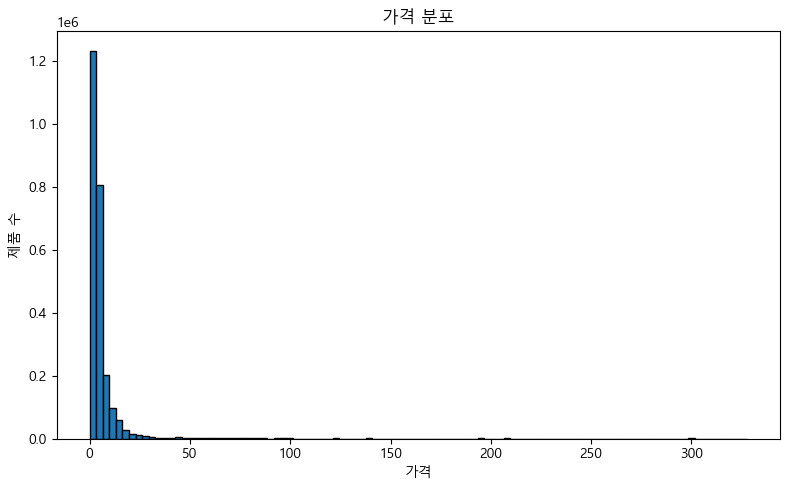

In [12]:
# 분포 확인하기
import pandas as pd
import matplotlib.pyplot as plt

# 한글 폰트 설정 (윈도우 기준)
from matplotlib import rc
rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# 히스토그램
plt.figure(figsize=(8, 5))
plt.hist(df['price'], bins=100, edgecolor='black')
plt.title("가격 분포")
plt.xlabel("가격")
plt.ylabel("제품 수")
plt.tight_layout()
plt.show()

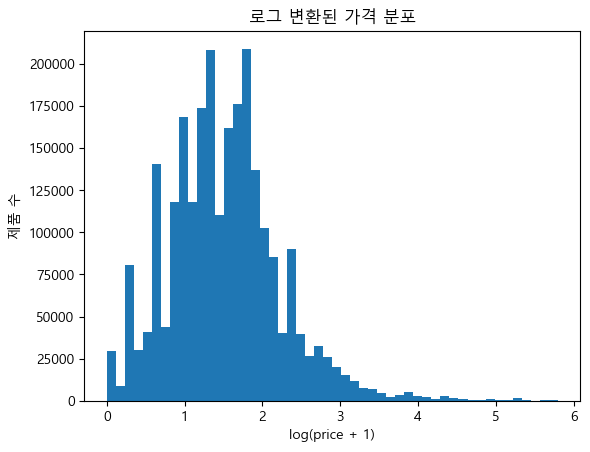

In [14]:
import numpy as np
import matplotlib.pyplot as plt

log_prices = np.log1p(df['price'])
plt.hist(log_prices, bins=50)
plt.title("로그 변환된 가격 분포")
plt.xlabel("log(price + 1)")
plt.ylabel("제품 수")
plt.show()

In [16]:
import numpy as np
log_bins = [0, 1, 2, 3, 4, 5]

for i in range(len(log_bins) - 1):
    lower = np.exp(log_bins[i]) - 1
    upper = np.exp(log_bins[i+1]) - 1
    print(f"log(price+1) ∈ [{log_bins[i]}, {log_bins[i+1]}) → price ∈ [{lower:.2f}, {upper:.2f})")


log(price+1) ∈ [0, 1) → price ∈ [0.00, 1.72)
log(price+1) ∈ [1, 2) → price ∈ [1.72, 6.39)
log(price+1) ∈ [2, 3) → price ∈ [6.39, 19.09)
log(price+1) ∈ [3, 4) → price ∈ [19.09, 53.60)
log(price+1) ∈ [4, 5) → price ∈ [53.60, 147.41)


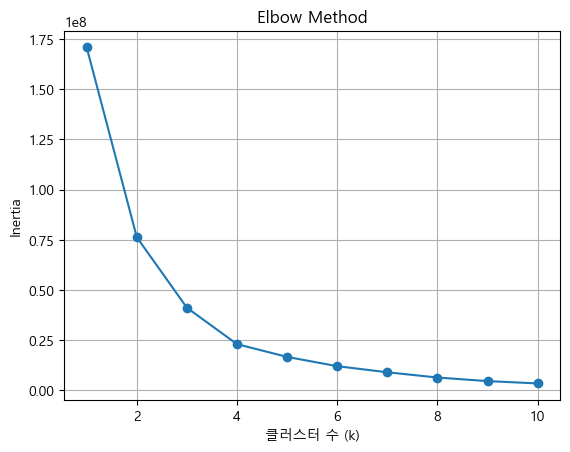

In [38]:
# 엘보우 기법으로 최적의 클러스터 수 찾기
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
k_range = range(1, 11)

for k in k_range:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    model.fit(df[['price']])
    inertias.append(model.inertia_)  # 잔차 제곱합 (within-cluster sum of squares)

# 시각화
plt.plot(k_range, inertias, marker='o')
plt.title("Elbow Method")
plt.xlabel("클러스터 수 (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


In [40]:
# 실루엣 점수로 최적의 클러스터 수 찾기
from sklearn.metrics import silhouette_score

scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df[['price']])
    score = silhouette_score(df[['price']], labels)
    scores.append(score)

plt.plot(range(2, 11), scores, marker='o')
plt.title("Silhouette Score by K")
plt.xlabel("클러스터 수 (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

MemoryError: Unable to allocate 1016. MiB for an array with shape (83, 1604434) and data type float64

In [4]:
# 가격 데이터 추출
price_df = df[['price']].copy()

In [5]:
# 클러스터링
from sklearn.cluster import KMeans

# 모델 생성 및 학습
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)
price_df['cluster'] = kmeans.fit_predict(price_df[['price']])

In [6]:
# 라벨링
import numpy as np

# 중심값 추출 및 정렬
centers = kmeans.cluster_centers_.flatten()
sorted_indices = np.argsort(centers)

# 라벨 매핑: 중심값 낮은 순서대로 low → mid → high
label_map = {sorted_indices[0]: 'low', sorted_indices[1]: 'mid', sorted_indices[2]: 'high'}
price_df['price_group'] = price_df['cluster'].map(label_map)

price_df.head()

,price,cluster,price_group
0,1.19,0,low
1,1.19,0,low
2,4.44,0,low
3,0.40,0,low
4,2.79,0,low


C:\Users\tpfkv\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


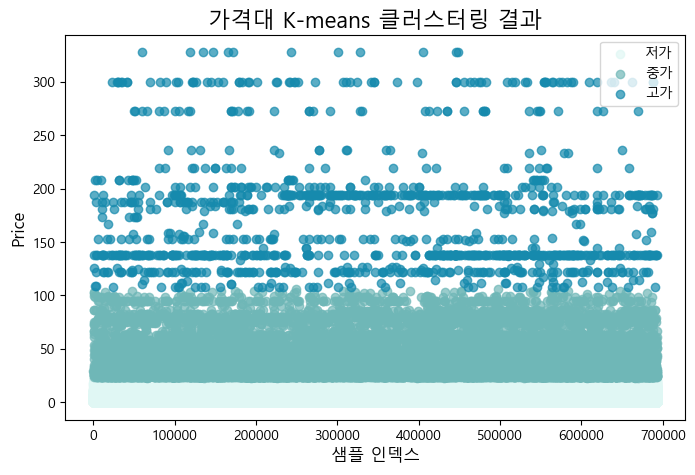

In [19]:
# 시각화
import matplotlib.pyplot as plt
from matplotlib import rc

# 한글 폰트 설정 (윈도우 기준)
rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# 한글 라벨과 색상 매핑
group_labels = {'low': '저가', 'mid': '중가', 'high': '고가'}
group_colors = {'low': '#E0F7F4', 'mid': '#6FB7B7', 'high': '#168AAD'}

plt.figure(figsize=(8, 5))

# 그룹별 시각화
for group in ['low', 'mid', 'high']:
    subset = price_df[price_df['price_group'] == group]
    plt.scatter(subset.index, subset['price'],
                label=group_labels[group],
                color=group_colors[group],
                alpha=0.7)

plt.title("가격대 K-means 클러스터링 결과", fontsize=16)
plt.xlabel("샘플 인덱스", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend()
plt.show()

In [24]:
# 인덱스 맞춰서 원본 데이터에 price_group 붙이기
df['price_group'] = price_df['price_group'].values

In [26]:
df.head()

,price,user_id,user_session,product_id,has_cart,has_purchase,has_remove,cart_status,price_group
0,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554,4958.0,1.0,1.0,0.0,purchase,low
1,1.19,579966747,1512be50-d0fd-4a92-bcd8-3ea3943f2a3b,5629988.0,1.0,0.0,0.0,implicit_abandon,low
2,4.44,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5,5807805.0,1.0,0.0,0.0,implicit_abandon,low
3,0.40,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554,5335.0,1.0,1.0,0.0,purchase,low
4,2.79,579751441,8de492d7-0937-47ae-be2c-a7615aec2b0d,5755170.0,1.0,0.0,0.0,implicit_abandon,low


In [30]:
# 가격대별 cart_status 개수 및 비율 집계
status_counts = df.groupby(['price_group', 'cart_status']).size().reset_index(name='count')
total_counts = status_counts.groupby('price_group')['count'].transform('sum')
status_counts['ratio'] = status_counts['count'] / total_counts

print(status_counts)

  price_group       cart_status   count     ratio
0        high  explicit_abandon     236  0.197160
1        high  implicit_abandon     810  0.676692
2        high          purchase     151  0.126149
3         low  explicit_abandon  139017  0.205083
4         low  implicit_abandon  446779  0.659104
5         low          purchase   92062  0.135813
6         mid  explicit_abandon    2744  0.199913
7         mid  implicit_abandon    8973  0.653723
8         mid          purchase    2009  0.146365


In [ ]:
# 클러스터링
from sklearn.cluster import KMeans

# 모델 생성 및 학습
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)
price_df['cluster'] = kmeans.fit_predict(price_df[['price']])

# 라벨링
import numpy as np

# 중심값 추출 및 정렬
centers = kmeans.cluster_centers_.flatten()
sorted_indices = np.argsort(centers)

# 라벨 매핑: 중심값 낮은 순서대로 low → mid → high → very high
label_map = {sorted_indices[0]: 'low', sorted_indices[1]: 'mid', sorted_indices[2]: 'high'}
price_df['price_group'] = price_df['cluster'].map(label_map)

price_df.head()

In [3]:
# 파일 불러오기
file_path = "C:/Users/tpfkv/OneDrive/문서/2025/Prj-CosmeticEcommerceConversion/"
brand_score_df = pd.read_csv(file_path+'brandScore.csv')

brand_score_df.head()

,brand,view_cnt,cart_cnt,norm_view,norm_cart,brand_score
0,runail,352088,271920,1.0000,1.0000,1.0000
1,irisk,238733,183432,0.6780,0.6746,0.6750
2,grattol,251121,123752,0.7132,0.4551,0.4835
3,masura,185567,127655,0.5270,0.4695,0.4758
4,ingarden,95685,63691,0.2718,0.2342,0.2384


In [5]:
from sklearn.cluster import KMeans
import numpy as np

# Prepare the data: brand_score as 1D array for KMeans
scores = brand_score_df[['brand_score']].copy()

# Apply KMeans clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
brand_score_df['cluster'] = kmeans.fit_predict(scores)

# Map cluster labels to 'low', 'mid', 'high' based on cluster centers
centers = kmeans.cluster_centers_.flatten()
sorted_labels = np.argsort(centers)  # label with lowest center → 'low'

# Create mapping from cluster number to label
label_mapping = {sorted_labels[0]: 'low', sorted_labels[1]: 'mid', sorted_labels[2]: 'high'}
brand_score_df['brand_group_clustered'] = brand_score_df['cluster'].map(label_mapping)

# Show result
import ace_tools as tools; tools.display_dataframe_to_user(name="클러스터링 기반 브랜드 그룹", dataframe=brand_score_df)
brand_score_df.head()


C:\Users\tpfkv\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


ModuleNotFoundError: No module named 'ace_tools'